In [ ]:
import matplotlib.pyplot as plt
from image_util import I

## Filters
---


forward difference: $ f'(x) = \frac{f(x+h) - f(x)}{h}$

backward difference: $ f'(x) = \frac{f(x) - f(x-h)}{h}$

central difference: $f'(x)=\frac{f(x+h) - f(x-h)}{2h}$

### Padding

In [ ]:
import copy

def pad_image(image, padding_height, padding_width):
    image = copy.deepcopy(image) # Avoid modifying the original image
    padded_image = []
    rows = len(image)
    cols = len(image[0])
    channels = len(image[0][0]) if type(image[0][0]) == list else 1 

    # Adjust channels
    zeros = [0] * channels
    if (channels == 1):
        zeros = 0

    # Pad rows at the top and bottom
    for i in range(padding_height):
        padded_image.append([zeros] * cols)
    for row in image:
        padded_image.append(row)
    for i in range(padding_height):
        padded_image.append([zeros] * cols)

    # Pad columns at the left and right
    for i in range(len(padded_image)):
        for j in range(padding_width):
            padded_image[i].insert(0, zeros)
        for j in range(padding_width):
            padded_image[i].append(zeros)

    return copy.deepcopy(padded_image)

### Convolution

In [ ]:
import copy

def convolution(image, kernel):
    '''
    Performs convolution between an image and a kernel
    '''
    image = copy.deepcopy(image) # Avoid modifying the original image
    
    padding_height = len(kernel) // 2
    padding_width = len(kernel[0]) // 2
    
    # Pad the image
    padded_image = pad_image(image, padding_height, padding_width)
    
    # Create an output matrix with the same dimensions as the input image
    output = [[0] * len(image[0]) for i in range(len(image))]

    # Perform convolution
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])
    
    for i in range(image_height):
        for j in range(image_width):
            for k in range(kernel_height):
                for l in range(kernel_width):
                    # kernel multiplication
                    if type(padded_image[i + k][j + l]) == list:
                        result = [x * kernel[k][l] for x in padded_image[i + k][j + l]]
                    else: # Assume it's a number
                        result = padded_image[i + k][j + l] * kernel[k][l]
                    output[i][j] = output[i][j] + int(result)
    return output

In [ ]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
gray = I.to_gray(img)
conv = convolution(gray, kernel=[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
I.show(conv, gray=True)

### Edge detection

In [ ]:
from canny_operator import canny_edge_detector

In [ ]:
def edge_detection(
    img: list,
    x_kernel: list = [[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]],
    y_kernel: list = [[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]]
    ) -> list:
    '''
    detect edges in an image
    '''
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # create edge image
    edge = []
       
    # calculate the gradient in the x-direction and y-direction
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
        
    # loop through the image
    for i in range(len(img)):
        edge.append([])
        for j in range(len(img[0])):
            # remove edge pixels in image boundary
            if i == 0 or i == len(img) - 1 or j == 0 or j == len(img[0]) - 1:
                edge[i].append([0])
                continue
            # calculate the gradient magnitude
            edge[i].append([int((Ix[i][j]**2 + Iy[i][j]**2)**0.5)])
            
    return edge

In [ ]:
def edge_threshold(edge: list, threshold: int = 100) -> list:
    '''
    threshold the edge image
    '''
    # create a copy of the edge image
    edge = copy.deepcopy(edge)
    
    # loop through the image
    for i in range(len(edge)):
        for j in range(len(edge[0])):
            # threshold the pixel
            if edge[i][j][0] > threshold:
                edge[i][j] = 255
            else:
                edge[i][j] = 0
                
    return edge

In [ ]:
img = I.from_np(plt.imread('data/no_bg/img/sapi1.jpg')).image
edge = edge_detection(img)
# set threshold
edge = edge_threshold(edge, threshold=100)

I.show(edge, gray=True)

In [ ]:
bg = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
edge = edge_detection(bg)
edge = edge_threshold(edge, threshold=100)
I.show(edge, gray=True)

### Median Filter

In [ ]:
def median_filter(gray_img, mask=3):
    """
    :param gray_img: gray image
    :param mask: mask size
    :return: image with median filter
    """
    # set image borders
    bd = int(mask / 2)
    
    row = len(gray_img)
    col = len(gray_img[0])
    
    # copy image size
    median_img = [[0] * col for i in range(row)]
    
    for i in range(bd, row - bd):
        for j in range(bd, col - bd):
            # get mask according with mask
            kernel = [[gray_img[i - bd + k][j - bd + l] for l in range(mask)] for k in range(mask)]
            kernel = I.flatten(kernel)
            sorted_list = sorted(kernel)
            # calculate mask median
            median = sorted_list[int(len(sorted_list) / 2)]
            median_img[i][j] = median
    return median_img

In [ ]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
gray = I.to_gray(img)
median = median_filter(gray, mask=5)
I.show(median, gray=True)

### Gaussian Filter

In [ ]:
import math

def generate_gaussian_kernel(size, sigma):
    kernel = [[0.0] * size for _ in range(size)]
    center = size // 2
    total = 0.0

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            exponent = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
            kernel[i][j] = math.exp(exponent)
            total += kernel[i][j]

    # Normalize the kernel
    for i in range(size):
        for j in range(size):
            kernel[i][j] /= total
            kernel[i][j] = round(kernel[i][j], 2)

    return kernel

In [ ]:
gaussian_kernel = generate_gaussian_kernel(5, 2)
gaussian_kernel

In [ ]:
blurred_img = convolution(gray, gaussian_kernel)

In [ ]:
I.show(blurred_img, gray=True)

In [ ]:
edge = edge_detection(blurred_img)
edge = edge_threshold(edge, threshold=110)
I.show(edge, gray=True)

### Find Connected Components

In [51]:
import copy

def connected_components(binary_image, min_size=100):
    '''
    Find and label connected components in a binary image
    input: binary image (2D array)
    output: labeled image (2D array), dictionary of component sizes, number of components
    '''
    binary_image = copy.deepcopy(binary_image) # Make sure we don't overwrite the original image
    height, width = len(binary_image), len(binary_image[0])
    label_matrix = [[0] * width for _ in range(height)]  # Initialize empty label matrix

    label = 0  # Start label
    label_dict = {}  # Keep track of which label corresponds to which connected component
    component_sizes = {}  # Keep track of component sizes
    
    # First pass
    for i in range(height):
        for j in range(width):            
            if binary_image[i][j] == 0: # background pixel
                continue
            
            if i == 0 and j == 0: # first pixel
                continue
            try:
                # check neighbors (8-connectivity)
                neighbors = [binary_image[i][j-1], 
                            binary_image[i-1][j-1], 
                            binary_image[i-1][j],
                            binary_image[i-1][j+1]]
                
                # check neighbors (4-connectivity)
                # neighbors = [padded_image[i][j-1],
                #              padded_image[i-1][j]]

                if sum(neighbors) == 0: # no neighbors
                    label += 1 # increment label
                    label_dict[label] = [label] # create new label
                    label_matrix[i][j] = label # assign label to pixel
                else:
                    matrix_neighbors = [label_matrix[i][j-1], 
                                    label_matrix[i-1][j-1], 
                                    label_matrix[i-1][j],
                                    label_matrix[i-1][j+1]]
                    try:
                        min_label = min(num for num in matrix_neighbors if num > 0) # get min label from neighbors
                    except:
                        continue                    
                    label_matrix[i][j] = min_label # assign min label to pixel
                    label_dict[label_matrix[i][j]].append(min_label) # add label to label_dict
            except IndexError:
                continue
    # Second pass
    for i in range(height):
        for j in range(width):
            if label_matrix[i][j] == 0:
                continue
            
            label_matrix[i][j] = min(label_dict[label_matrix[i][j]]) # assign min label to pixel
            component_sizes[label_matrix[i][j]] = component_sizes.get(label_matrix[i][j], 0) + 1  # increment component size
    
    # Remove small components
    for i in range(height):
        for j in range(width):
            label = label_matrix[i][j]
            if label != 0 and component_sizes[label] < min_size:
                label_matrix[i][j] = 0
    
    return label_matrix, component_sizes, label_dict

In [ ]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
img = I.bl_resize(original_img=img, new_h=200, new_w=200)
I.show(img)

gray = I.to_gray(img)
gaussian_kernel = generate_gaussian_kernel(3, 0.6)
blurred_img = convolution(gray, gaussian_kernel)
I.show(blurred_img, gray=True)

# edge = edge_detection(blurred_img)
# edge = edge_threshold(edge, threshold=100)
edge = canny_edge_detector(img=img, low=0.65, high=0.7, hyst=False)
I.show(edge, gray=True)

In [ ]:
import copy

def dilate(image, kernel, k):
    '''
    Performs dilation operation on a binary image using a kernel
    input: binary image (2D array), kernel (2D array), number of iterations
    output: dilated image (2D array)
    '''
    image = copy.deepcopy(image)  # Avoid modifying the original image
    
    height, width = len(image), len(image[0])
    kernel_height, kernel_width = len(kernel), len(kernel[0])
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2
    
    padded_image = pad_image(image, padding_height, padding_width)
    
    for _ in range(k):
        for i in range(height):
            for j in range(width):
                if image[i][j] == 1:
                    for k in range(kernel_height):
                        for l in range(kernel_width):
                            if kernel[k][l] == 1:
                                padded_image[i + k][j + l] = 1
                                
        image = copy.deepcopy(padded_image)
    
    # Remove padding
    for i in range(padding_height):
        image.pop(0)
        image.pop()
    for row in image:
        for i in range(padding_width):
            row.pop(0)
            row.pop()
            
    return image

def erode(image, kernel):
    '''
    Performs erosion operation on a binary image using a kernel
    '''
    image = copy.deepcopy(image)  # Avoid modifying the original image
    
    height, width = len(image), len(image[0])
    kernel_height, kernel_width = len(kernel), len(kernel[0])
    padding_height = kernel_height // 2
    padding_width = kernel_width // 2
    
    padded_image = pad_image(image, padding_height, padding_width)
    
    for i in range(height):
        for j in range(width):
            if image[i][j] == 1:
                matched = True
                for k in range(kernel_height):
                    for l in range(kernel_width):
                        if kernel[k][l] == 1 and padded_image[i + k][j + l] != 1:
                            matched = False
                            break
                    if not matched:
                        break
                if matched:
                    padded_image[i + padding_height][j + padding_width] = 1
                else:
                    padded_image[i + padding_height][j + padding_width] = 0
                    
    # Remove padding
    for i in range(padding_height):
        padded_image.pop(0)
        padded_image.pop()
    for row in padded_image:
        for i in range(padding_width):
            row.pop(0)
            row.pop()
            
    return padded_image


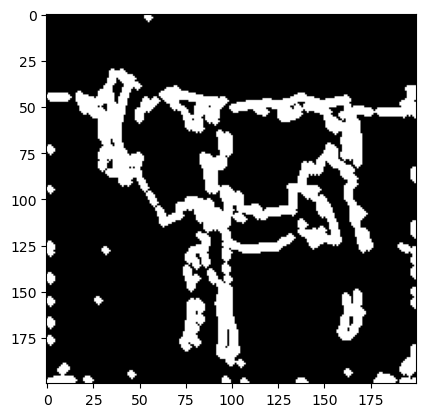

In [54]:
# normalize edges to 0 and 1
norm = [[0 if i == 0 else 1 for i in j] for j in edge]

dilated = dilate(norm, kernel=[[0, 1, 0], [1, 1, 1], [0, 1, 0]], k=2)
I.show(dilated, gray=True)

label_matrix, component_sizes, label_dict = connected_components(binary_image=dilated, min_size=100)

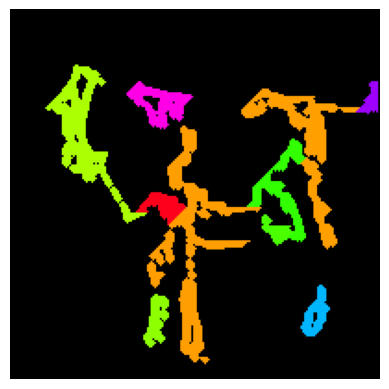

In [55]:
import matplotlib.pyplot as plt
import random
import colorsys

def plot_label_matrix(label_matrix):
    height, width = len(label_matrix), len(label_matrix[0])
    unique_labels = set(sum(label_matrix, [])) - {0}  # Get unique labels excluding background (label 0)
    num_labels = len(unique_labels)
    
    # Generate random colors for each label
    label_colors = {}
    for label in unique_labels:
        # random hue
        hue = random.random()
        hsv = (hue, 1, 1)
        rgb = colorsys.hsv_to_rgb(*hsv)
        label_colors[label] = rgb
    
    # Create an RGB image based on the label matrix
    rgb_image = [[label_colors[label] if label in label_colors else (0, 0, 0) for label in row] for row in label_matrix]
    
    # Display the labeled image
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.show()

plot_label_matrix(label_matrix=label_matrix)

## Implement
---